# CAL studies

In [1]:
import ROOT as R
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

Welcome to JupyROOT 6.30/04


In [2]:
df = pd.read_feather('datos/loop_0.feather')

In [3]:
# Define ranges of cal code
cal_range = {'B0': [160,178],
             'B1': [160,180],
             'B2': [155,185],
             'B3': [200,250]}

In [4]:
def draw1Dhist(hist, opt="HIST"):
    c = R.TCanvas(f"c_{hist.GetName()}","")
    c.cd()
    c.SetLogy(0)
    hist.Draw(opt)
    return c

def drawProfile2D(hcalprof, zmin, zmax):
    c = R.TCanvas(f"c_{hcalprof.GetName()}","")
    c.cd()
    R.gStyle.SetPaintTextFormat("0.f")
    hcalprof.SetMinimum(zmin)
    hcalprof.SetMaximum(zmax)
    hcalprof.Draw("COLZ,TEXT")
    return c

In [5]:
def getPixelMaximum(df, board, col, row):
    dft = df[df['board']==board]
    dft = dft[dft['col']==col]
    dft = dft[dft['row']==row]
    cal = np.array(dft['cal'], dtype=float)
    if len(cal) == 0: return 0
    h = R.TH1F(f"h{col}{row}", "", 1023, 0., 1024.) # CAL ranges between 0 and 1023
    h.FillN(len(cal), cal, np.ones(len(cal)))
    maxval = h.GetMaximumBin()
    return maxval

In [10]:
def analyzeCAL(df, board, CALrange, useprof=False):
    df_temp = df[df['board']==board]
    # Only accept CAL values in a range
    cal_sel = np.array(df_temp['cal']>CALrange[0]) * np.array(df_temp['cal']<CALrange[1])
    df_temp = df_temp[cal_sel]
    
    cal_0 = np.array(df_temp['cal'], dtype=float)
    MIN = CALrange[0]
    MAX = CALrange[1]
    BINS = MAX-MIN
    hcal = R.TH1F("hcal", f"Board {board};CAL code;N events", BINS, MIN, MAX)
    hcal.FillN(len(cal_0), cal_0, np.ones(len(cal_0)))

    # Get mean cal using a TProfile
    if useprof:
        hcalprof = R.TProfile2D("hcalprof", f"Board {board};col;row", 16, -0., 16., 16, -0., 16.)
        row_0 = np.array(df_temp['row'], dtype=float)
        col_0 = np.array(df_temp['col'], dtype=float)
        for i in tqdm(range(len(cal_0))):
            hcalprof.Fill(col_0[i], row_0[i], cal_0[i])
    # Get cal value using the maximum of the distribution (more robust but slower)
    else:
        hcalprof = R.TH2F("hcalprof", f"Board {board};col;row", 16, -0., 16., 16, -0., 16.)
        for row in tqdm(range(16)):
            for col in range(16):
                hcalprof.Fill(col, row, getPixelMaximum(df,board,col,row))
    return hcal, hcalprof, df_temp

In [7]:
R.gROOT.ProcessLine('.L ./tdrstyle.C')
R.gROOT.SetBatch(1)
R.setTDRStyle()

In [11]:
hcal0, hprof0, df0 = analyzeCAL(df, 0, cal_range['B0'])
hcal1, hprof1, df1 = analyzeCAL(df, 1, cal_range['B1'])
hcal2, hprof2, df2 = analyzeCAL(df, 2, cal_range['B2'])
hcal3, hprof3, df3 = analyzeCAL(df, 3, cal_range['B3'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]
Warning in <TROOT::Append>: Replacing existing TH1: hcal (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hcalprof (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hcal (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hcalprof (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hcal (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hcalprof (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hcal (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hcalprof (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cprof


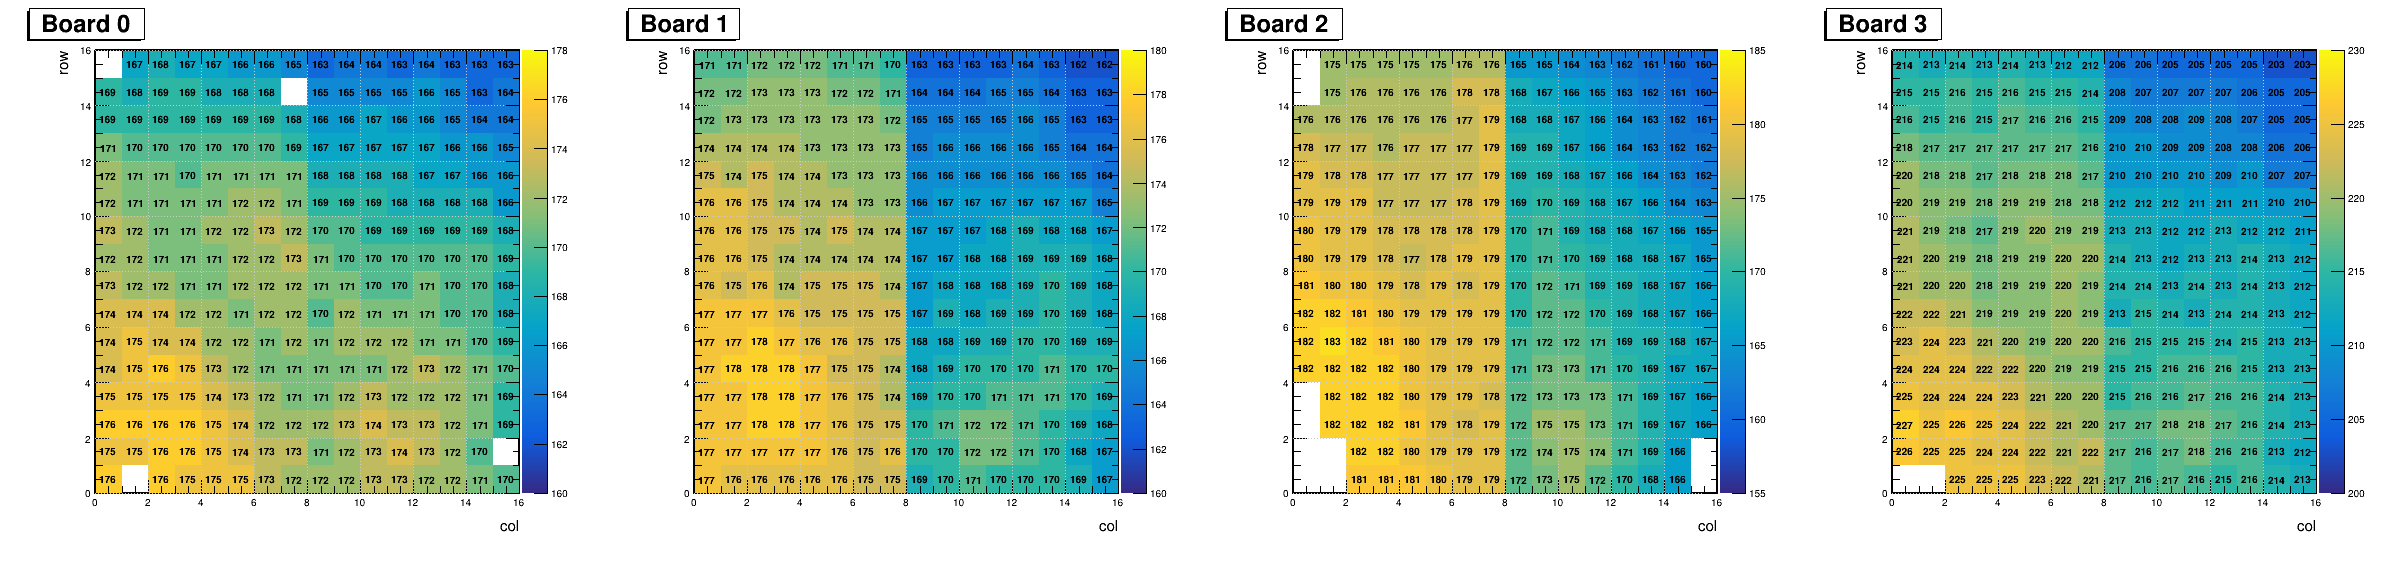

In [12]:
R.gStyle.SetPaintTextFormat("0.f")
cprof = R.TCanvas("cprof","",2400,600)
cprof.Divide(4,1)
cprof.cd(1)
hprof0.Draw("COLZ,TEXT")
hprof0.SetMinimum(cal_range['B0'][0])
hprof0.SetMaximum(cal_range['B0'][1])
cprof.cd(2)
hprof1.Draw("COLZ,TEXT")
hprof1.SetMinimum(cal_range['B1'][0])
hprof1.SetMaximum(cal_range['B1'][1])
cprof.cd(3)
hprof2.Draw("COLZ,TEXT")
hprof2.SetMinimum(cal_range['B2'][0])
hprof2.SetMaximum(cal_range['B2'][1])
cprof.cd(4)
hprof3.Draw("COLZ,TEXT")
hprof3.SetMinimum(cal_range['B3'][0])
hprof3.SetMaximum(230.)
cprof.Draw()

In [13]:
acal = []
row = np.array(df0['row'], dtype=float)
col = np.array(df0['col'], dtype=float)
for i in tqdm(range(len(df0))):
    acal.append(hprof0.GetBinContent(int(col[i])+1, int(row[i])+1))
df0['acal'] = acal

acal = []
row = np.array(df1['row'], dtype=float)
col = np.array(df1['col'], dtype=float)
for i in tqdm(range(len(df1))):
    acal.append(hprof1.GetBinContent(int(col[i])+1, int(row[i])+1))
df1['acal'] = acal

acal = []
row = np.array(df2['row'], dtype=float)
col = np.array(df2['col'], dtype=float)
for i in tqdm(range(len(df2))):
    acal.append(hprof2.GetBinContent(int(col[i])+1, int(row[i])+1))
df2['acal'] = acal

acal = []
row = np.array(df3['row'], dtype=float)
col = np.array(df3['col'], dtype=float)
for i in tqdm(range(len(df3))):
    acal.append(hprof3.GetBinContent(int(col[i])+1, int(row[i])+1))
df3['acal'] = acal

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1286462/1286462 [00:00<00:00, 1536108.40it/s]


# Pairwise TOA without TWC

In [14]:
start = time.time()
tracks_df = pd.concat([df0,df1,df2,df3])

# Select cals within 1 unit from the peak
calsel = np.abs(tracks_df['acal']-tracks_df['cal'])<1.1
tracks_df = tracks_df[calsel]

tracks_df = tracks_df.groupby('evt').filter(lambda x: len(x)==4 and len(x['board']) == len(np.unique(x['board'])))
end = time.time()
print(f"Elapsed time: {end-start:.3f} s")
tracks_df

Elapsed time: 59.808 s


,evt,bcid,l1a_counter,ea,board,row,col,toa,tot,cal,acal
25,7,2318,203,0,0,15,1,192,100,167,167.0
43,12,3436,208,0,0,8,6,89,110,172,172.0
47,13,1438,209,0,0,11,3,420,109,170,170.0
62,18,3482,214,0,0,9,10,460,91,170,169.0
66,19,1075,215,0,0,9,4,291,115,171,172.0
...,...,...,...,...,...,...,...,...,...,...,...
6569180,1784678,2513,180,0,3,0,10,332,176,217,217.0
6569192,1784680,151,182,0,3,7,6,222,136,220,220.0
6569205,1784684,1206,186,0,3,12,5,586,150,216,217.0
6569224,1784690,719,192,0,3,10,8,169,172,212,212.0


# Apply Time Walk Correction

### 1. Convert to ps

In [15]:
tracks_df['toa_ps'] = 1000*(12.5-tracks_df['toa']*3.125/tracks_df['acal'])
tracks_df['tot_ps'] = 1000*((2.*tracks_df['tot']-np.floor(tracks_df['tot']/32.))*3.125/tracks_df['acal'])

In [41]:
def plotMulti1D(c, hists, names, colors):
    c = R.TCanvas(f"{c}","")
    c.cd()
    l = R.TLegend(0.6,0.2,0.8,0.4)
    for i,h in enumerate(hists):
        if i==0: h.Draw("HIST")
        else: h.Draw("HIST,SAME")
        h.SetLineColor(colors[i])
        l.AddEntry(h, names[i],"L")
    return c, l

Warning in <TCanvas::Constructor>: Deleting canvas with same name: ctoa
Warning in <TCanvas::Constructor>: Deleting canvas with same name: ctot


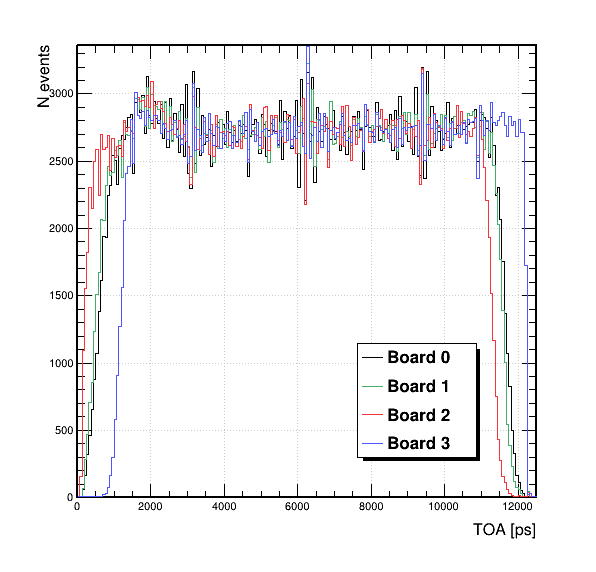

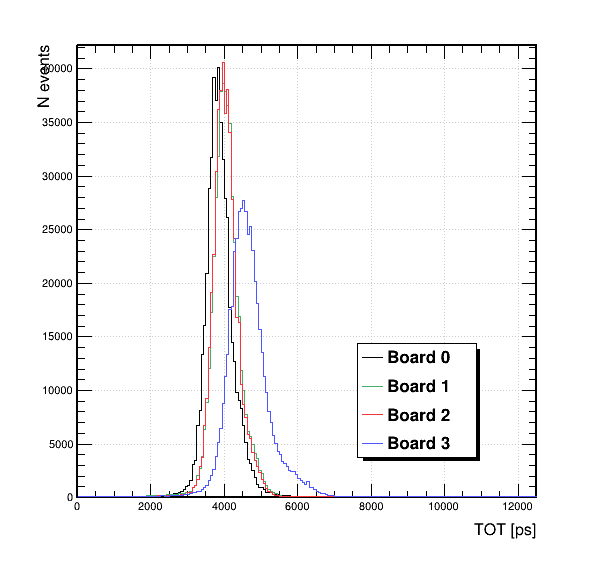

In [42]:
NBINS = 200

colors = [R.kBlack,
          R.TColor.GetColor("#44AF69"),
          R.TColor.GetColor("#F8333C"),
          R.TColor.GetColor("#5056FF")]
leg = []
toa, htoa = [], []
for i in range(4):
    toa.append(np.array(tracks_df[tracks_df['board']==i]['toa_ps'], dtype=float))
    htoa.append(R.TH1F(f"htoa{i}",";TOA [ps];N events", NBINS, 0., 12500.))
    htoa[i].FillN(len(toa[i]), toa[i], np.ones(len(toa[i])))
    leg.append(f"Board {i}")
ctoa, ltoa = plotMulti1D("ctoa", htoa, leg, colors)
ctoa.cd()
ltoa.Draw()

leg = []
tot, htot = [], []
for i in range(4):
    tot.append(np.array(tracks_df[tracks_df['board']==i]['tot_ps'], dtype=float))
    htot.append(R.TH1F(f"htot{i}",";TOT [ps];N events", NBINS, 0., 12500.))
    htot[i].FillN(len(tot[i]), tot[i], np.ones(len(tot[i])))
    leg.append(f"Board {i}")
ctot, ltot = plotMulti1D("ctot", htot, leg, colors)
ctot.cd()
ltot.Draw()

ctoa.Draw()
ctot.Draw()

In [18]:
# Compute delta ToA
print('- Computing deltaTOA...')
deltaTOA = []
for i in range(1,4):
    j = (i) % 3 + 1
    k = (i+1) % 3 + 1
    toai = np.array(tracks_df[tracks_df['board']==i]['toa_ps'])
    toaj = np.array(tracks_df[tracks_df['board']==j]['toa_ps'])
    toak = np.array(tracks_df[tracks_df['board']==k]['toa_ps'])
    deltaTOA.append((toaj+toak)/2-toai)

tot1 = np.array(tracks_df[tracks_df['board']==1]['tot_ps'])
tot2 = np.array(tracks_df[tracks_df['board']==2]['tot_ps'])
tot3 = np.array(tracks_df[tracks_df['board']==3]['tot_ps'])
toa1 = np.array(tracks_df[tracks_df['board']==1]['toa_ps'])
toa2 = np.array(tracks_df[tracks_df['board']==2]['toa_ps'])
toa3 = np.array(tracks_df[tracks_df['board']==3]['toa_ps'])

tot_all = np.concatenate((tot1,tot2,tot3))
deltaTOA_all = np.concatenate(deltaTOA)
print(f'Max tot = {np.max(abs(tot_all))}')
print(f'Max deltaTOA = {np.max(abs(deltaTOA_all))}')

- Computing deltaTOA...
Max tot = 18250.739644970414
Max deltaTOA = 11687.781935650222


In [56]:
deltaTOA_uppercut = []
tot = [tot1,tot2,tot3]
tot_uppercut = []
toa = [toa1,toa2,toa3]
toa_uppercut = []
for i in range(3):
    deltaTOA_uppercut.append(deltaTOA[i][deltaTOA[i]<2000])
    tot_uppercut.append(tot[i][deltaTOA[i]<2000])
    toa_uppercut.append(toa[i][deltaTOA[i]<2000])
    print(np.shape(deltaTOA[i]),np.shape(deltaTOA_uppercut[i]),np.shape(tot_uppercut[i]))

(484124,) (484025,) (484025,)
(484124,) (484018,) (484018,)
(484124,) (484024,) (484024,)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 484024/484024 [00:00<00:00, 1772907.35it/s]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h3 (Potential memory leak).


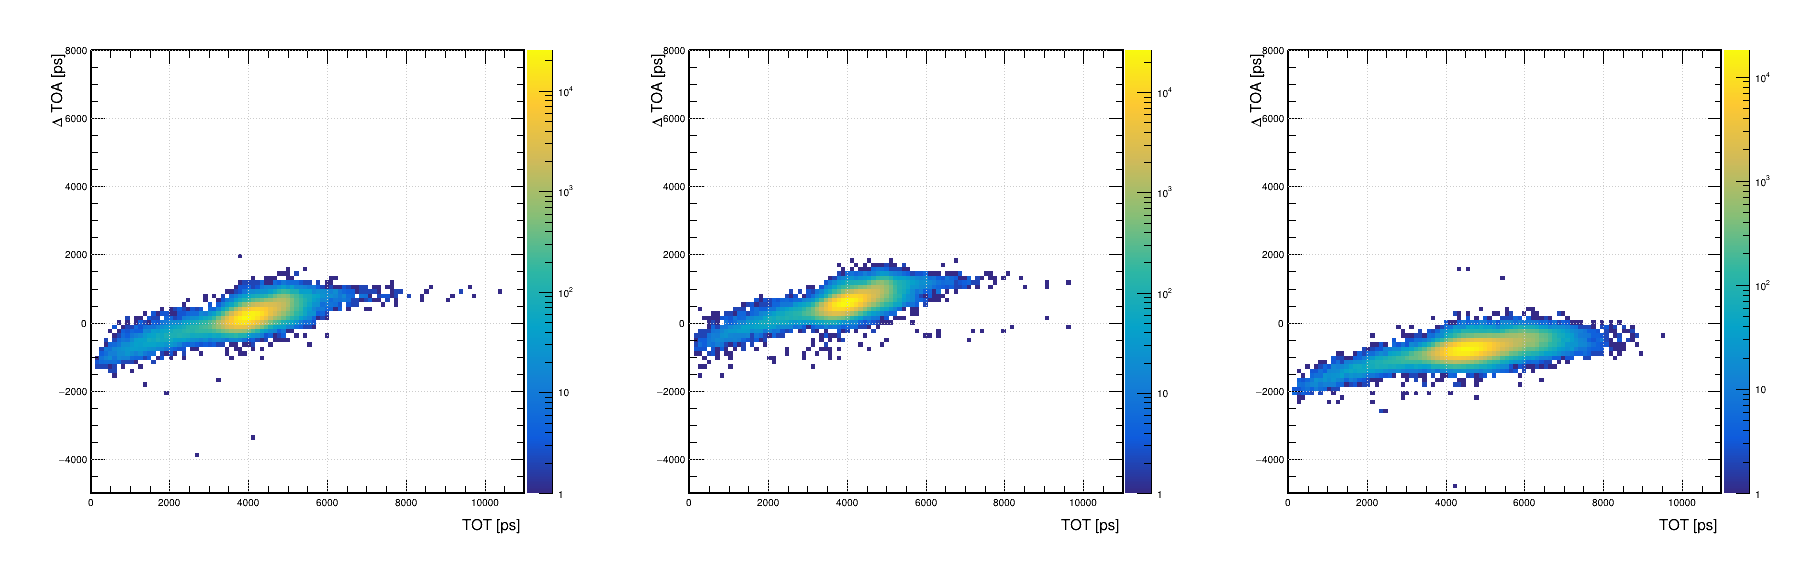

In [54]:
c1 = R.TCanvas("c1", "#Delta TOA", 1800, 600)  # Width = 1200, Height = 400
c1.Divide(3, 1)

h1 = R.TH2F("h1",";TOT [ps];#Delta TOA [ps]",100,0,11000.,100,-5000,8000)
h2 = R.TH2F("h2",";TOT [ps];#Delta TOA [ps]",100,0,11000.,100,-5000,8000)
h3 = R.TH2F("h3",";TOT [ps];#Delta TOA [ps]",100,0,11000.,100,-5000,8000)
h = [h1,h2,h3]
for j in range(3):
    for i in tqdm(range(len(tot_uppercut[j]))):
        h[j].Fill(tot_uppercut[j][i],deltaTOA_uppercut[j][i])
c1.GetPad(1).SetLogz()
c1.GetPad(2).SetLogz()
c1.GetPad(3).SetLogz()
c1.cd(1)
h1.Draw("COLZ")
c1.cd(2)
h2.Draw("COLZ")
c1.cd(3)
h3.Draw("COLZ")
c1.Draw()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 484024/484024 [00:00<00:00, 1775698.62it/s]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h3 (Potential memory leak).


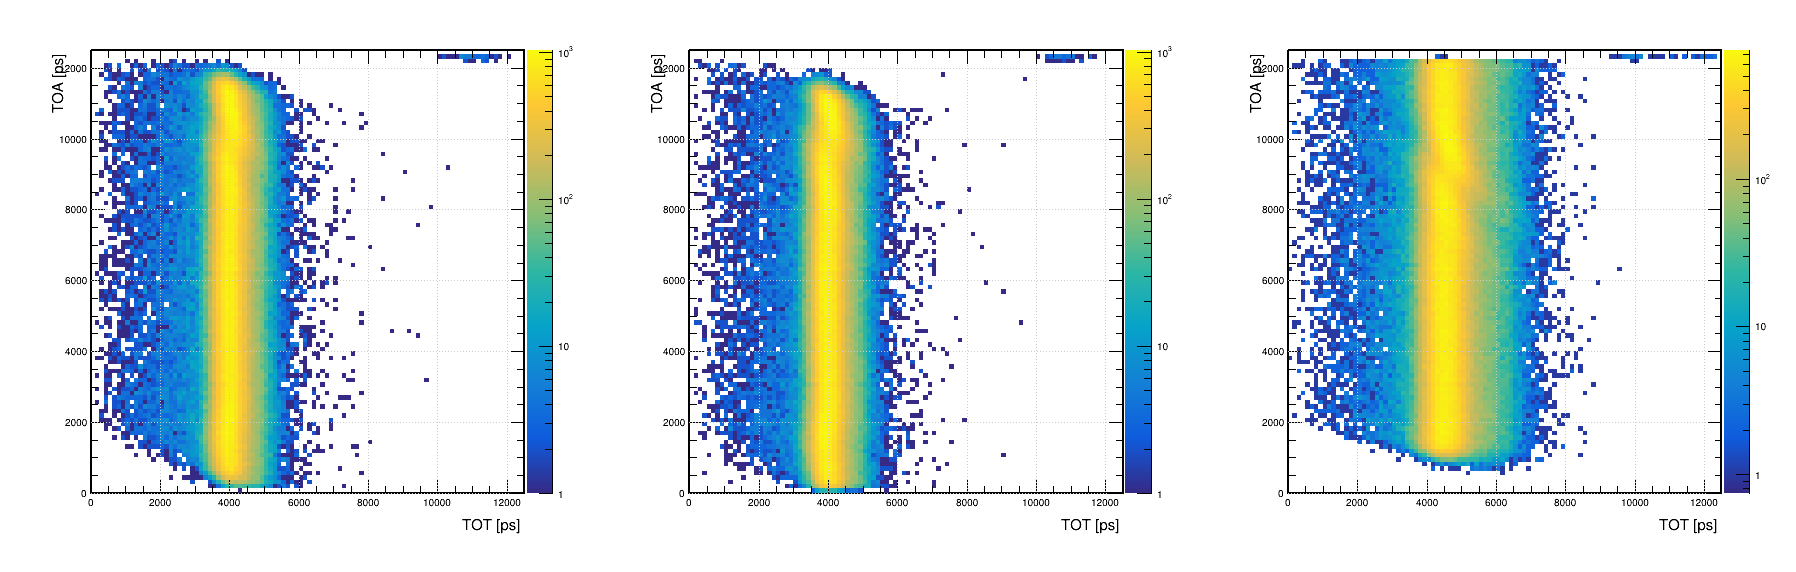

In [59]:
c1 = R.TCanvas("c1", "#Delta TOA", 1800, 600)  # Width = 1200, Height = 400
c1.Divide(3, 1)

h1 = R.TH2F("h1",";TOT [ps];TOA [ps]",100,0,12500.,100,0.,12500)
h2 = R.TH2F("h2",";TOT [ps];TOA [ps]",100,0,12500.,100,0.,12500)
h3 = R.TH2F("h3",";TOT [ps];TOA [ps]",100,0,12500.,100,0.,12500)
h = [h1,h2,h3]
for j in range(3):
    for i in tqdm(range(len(tot_uppercut[j]))):
        h[j].Fill(tot_uppercut[j][i],toa_uppercut[j][i])
c1.GetPad(1).SetLogz()
c1.GetPad(2).SetLogz()
c1.GetPad(3).SetLogz()
c1.cd(1)
h1.Draw("COLZ")
c1.cd(2)
h2.Draw("COLZ")
c1.cd(3)
h3.Draw("COLZ")
c1.Draw()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 484024/484024 [00:00<00:00, 1921860.42it/s]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h3 (Potential memory leak).


****************************************
Minimizer is Linear / Migrad
Chi2                      =      17410.1
NDf                       =           15
p0                        =      -1086.6   +/-   24.2278     
p1                        =     0.387506   +/-   0.0155682   
p2                        = -1.60429e-05   +/-   2.0944e-06  
****************************************
Minimizer is Linear / Migrad
Chi2                      =      17909.5
NDf                       =           15
p0                        =       -690.9   +/-   24.5728     
p1                        =     0.398108   +/-   0.0157899   
p2                        = -1.79868e-05   +/-   2.12422e-06 
****************************************
Minimizer is Linear / Migrad
Chi2                      =      11906.6
NDf                       =           15
p0                        =     -1954.29   +/-   20.0358     
p1                        =     0.368421   +/-   0.0128745   
p2                        = -2.31168e-05   +/-  

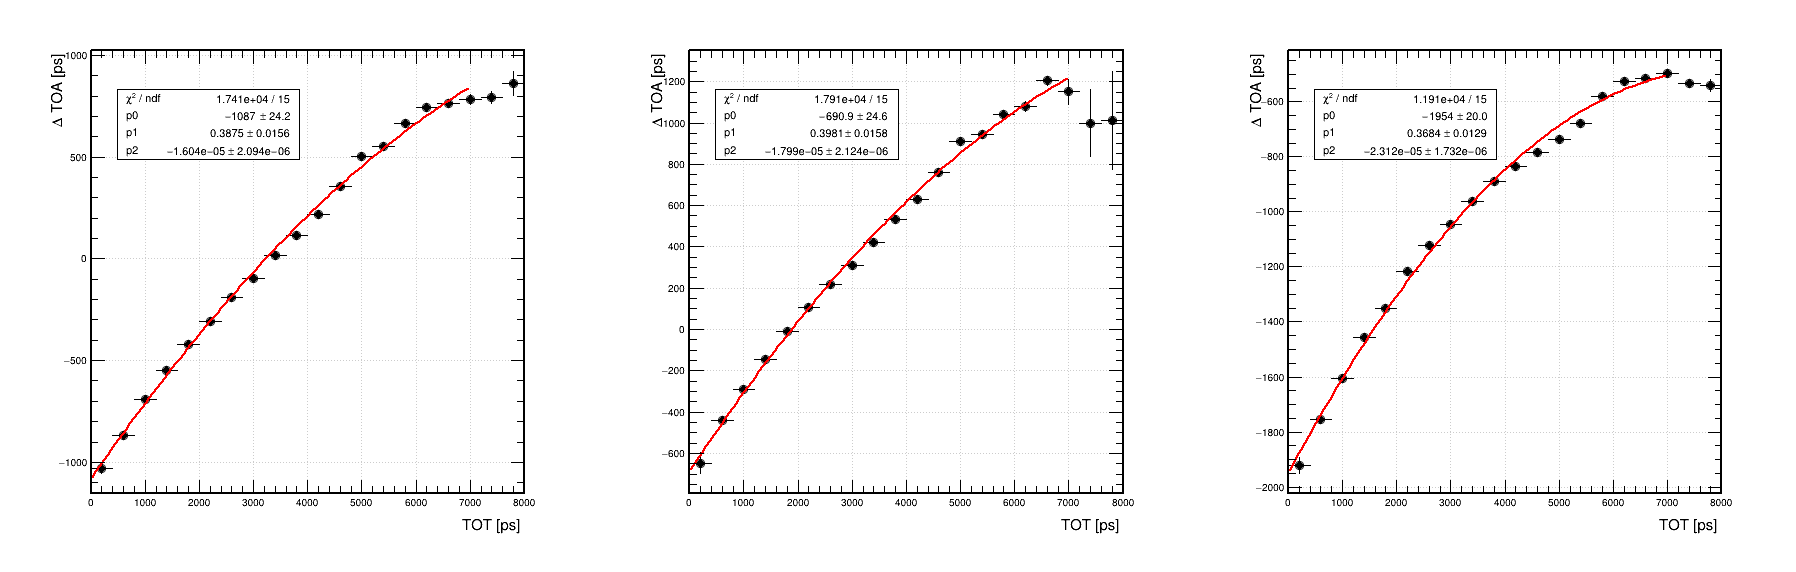

In [63]:
R.gStyle.SetStatX(0.5)
R.gStyle.SetStatY(0.85)
c1 = R.TCanvas("c1", "", 1800, 600)  # Width = 1200, Height = 400
c1.Divide(3, 1)

f1 = R.TF1("f1","pol2",0.,8000.)
f2 = R.TF1("f2","pol2",0.,8000.)
f3 = R.TF1("f3","pol2",0.,8000.)
h1 = R.TProfile("h1",";TOT [ps];#Delta TOA [ps]",20,0.,8000.)
h2 = R.TProfile("h2",";TOT [ps];#Delta TOA [ps]",20,0.,8000.)
h3 = R.TProfile("h3",";TOT [ps];#Delta TOA [ps]",20,0.,8000.)
h = [h1,h2,h3]
for j in range(3):
    for i in tqdm(range(len(tot_uppercut[j]))):
        h[j].Fill(tot_uppercut[j][i],deltaTOA_uppercut[j][i])
c1.cd(1)
h1.Draw("COLZ")
h1.Fit("f1","W","",0.,7000.)
c1.cd(2)
h2.Draw("COLZ")
h2.Fit("f2","W","",0.,7000.)
c1.cd(3)
h3.Draw("COLZ")
h3.Fit("f3","W","",0.,7000.)
c1.Draw()

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =  1.49387e+07
NDf                       =           97
Edm                       =  2.29227e-09
NCalls                    =           86
Constant                  =      14622.9   +/-   104.145     
Mean                      =     -273.655   +/-   1.48929     
Sigma                     =      185.384   +/-   1.59284      	 (limited)
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =  1.06043e+07
NDf                       =           97
Edm                       =  5.24058e-07
NCalls                    =           83
Constant                  =      14754.6   +/-   87.5444     
Mean                      =      911.002   +/-   1.10577     
Sigma                     =      164.462   +/-   1.16764      	 (limited)
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =  1.01296e+07
NDf                   

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h3 (Potential memory leak).


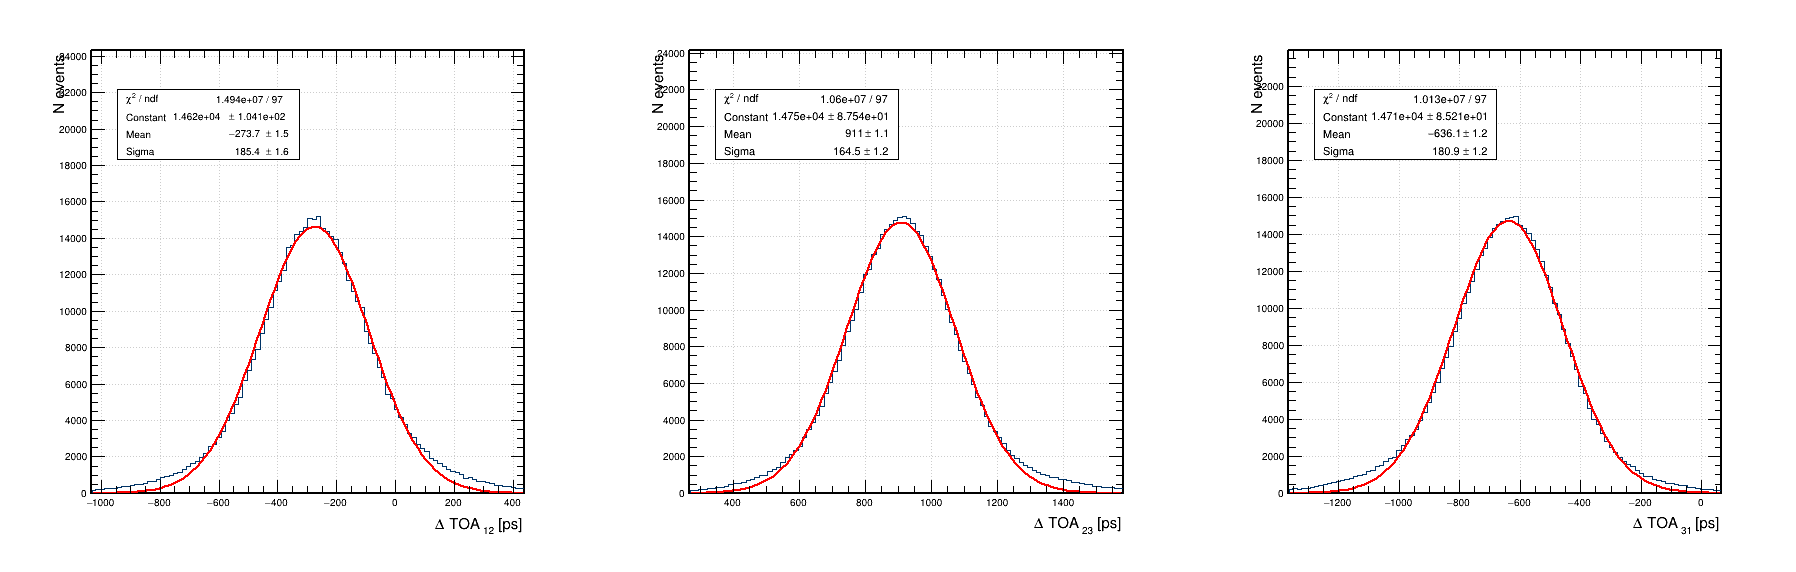

In [64]:
colorp = [R.TColor.GetColor("#44AF69"),
          R.TColor.GetColor("#F8333C"),
          R.TColor.GetColor("#2E3860"),
          R.kAzure+3]

toa1 = np.array(tracks_df[tracks_df['board']==1]['toa_ps'])
toa2 = np.array(tracks_df[tracks_df['board']==2]['toa_ps'])
toa3 = np.array(tracks_df[tracks_df['board']==3]['toa_ps'])

fg1 = R.TF1("fg1","gaus")
fg2 = R.TF1("fg2","gaus")
fg3 = R.TF1("fg3","gaus")
c1 = R.TCanvas("c1", "'#Delta TOA", 1800, 600)  # Width = 1200, Height = 400
c1.Divide(3, 1)

appr_mean = np.array([-298.6, 925, -650])
appr_sigma = np.array([184, 164, 179])
lowlim = appr_mean-4*appr_sigma
highlim = appr_mean+4*appr_sigma

l = R.TLatex()
l.SetTextSize(0.03)
l.SetTextAlign(12)
l.SetTextFont(42)

hists = []

h1 = R.TH1F("h1",";#Delta TOA_{12} [ps]; N events",100,lowlim[0],highlim[0])
h1.FillN(len(toa2-toa1), toa2-toa1, np.ones(len(toa1)))
hists.append(h1)

h2 = R.TH1F("h2",";#Delta TOA_{23} [ps]; N events",100,lowlim[1],highlim[1])
h2.FillN(len(toa3-toa2), toa3-toa2, np.ones(len(toa2)))
hists.append(h1)

h3 = R.TH1F("h3",";#Delta TOA_{31} [ps]; N events",100,lowlim[2],highlim[2])
h3.FillN(len(toa1-toa3), toa1-toa3, np.ones(len(toa3)))
hists.append(h1)

c1.cd(1)
h1.Fit("fg1","W","",lowlim[0],highlim[0])
h1.SetMaximum(h1.GetMaximum()*1.6)
h1.SetLineColor(colorp[3])
h1.Draw()
#l.DrawLatexNDC(0.17,0.8,f"#mu = {fg1.GetParameter(1):.1f}#pm {fg1.GetParError(1):.1f} ps")
#l.DrawLatexNDC(0.17,0.77,f"#sigma = {fg1.GetParameter(2):.1f}#pm {fg1.GetParError(2):.1f} ps")

c1.cd(2)
h2.Fit("fg2","W","",lowlim[1],highlim[1])
h2.SetMaximum(h2.GetMaximum()*1.6)
h2.SetLineColor(colorp[3])
h2.Draw()
#l.DrawLatexNDC(0.17,0.8,f"#mu = {fg2.GetParameter(1):.1f}#pm {fg2.GetParError(1):.1f} ps")
#l.DrawLatexNDC(0.17,0.77,f"#sigma = {fg2.GetParameter(2):.1f}#pm {fg2.GetParError(2):.1f} ps")

c1.cd(3)
h3.Fit("fg3","W","",lowlim[2],highlim[2])
h3.SetMaximum(h3.GetMaximum()*1.6)
h3.SetLineColor(colorp[3])
h3.Draw()
#l.DrawLatexNDC(0.17,0.8,f"#mu = {fg3.GetParameter(1):.1f}#pm {fg3.GetParError(1):.1f} ps")
#l.DrawLatexNDC(0.17,0.77,f"#sigma = {fg3.GetParameter(2):.1f}#pm {fg3.GetParError(2):.1f} ps")

c1.Draw()

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =  8.85525e+06
NDf                       =           97
Edm                       =  2.41317e-10
NCalls                    =           64
Constant                  =      21433.6   +/-   95.2229     
Mean                      =      130.893   +/-   0.653278    
Sigma                     =      129.297   +/-   0.682265     	 (limited)
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =  3.22534e+06
NDf                       =           97
Edm                       =  4.07193e-09
NCalls                    =           64
Constant                  =      20227.2   +/-   55.0457     
Mean                      =     -458.675   +/-   0.386813    
Sigma                     =      123.754   +/-   0.389035     	 (limited)
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =  3.75629e+06
NDf                   

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h3 (Potential memory leak).


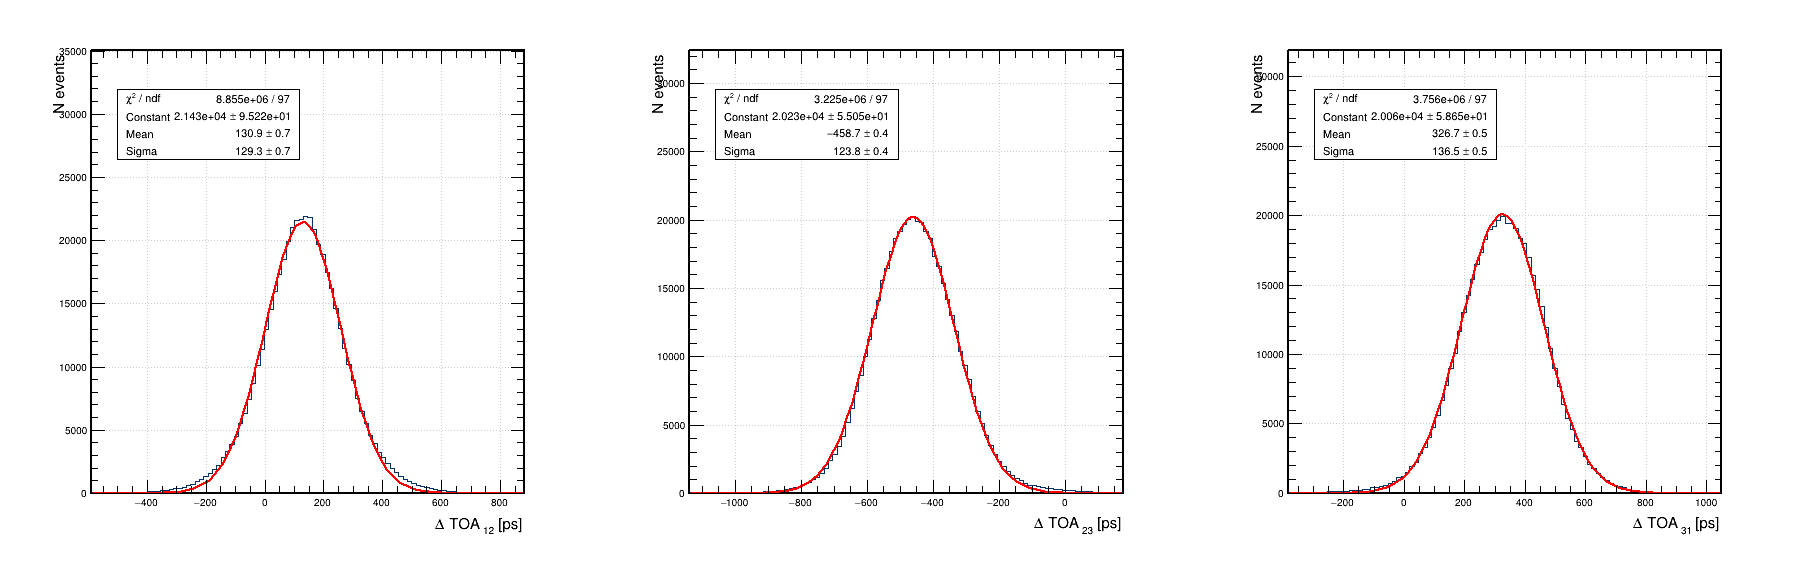

In [65]:
f1pars = [f1.GetParameter(0),f1.GetParameter(1),f1.GetParameter(2)]
f2pars = [f2.GetParameter(0),f2.GetParameter(1),f2.GetParameter(2)]
f3pars = [f3.GetParameter(0),f3.GetParameter(1),f3.GetParameter(2)]
ftot1 = f1pars[0] + f1pars[1]*tot1 + f1pars[2]*tot1*tot1
ftot2 = f2pars[0] + f2pars[1]*tot2 + f2pars[2]*tot2*tot2
ftot3 = f3pars[0] + f3pars[1]*tot3 + f3pars[2]*tot3*tot3
corrtoa1 = toa1 + ftot1
corrtoa2 = toa2 + ftot2
corrtoa3 = toa3 + ftot3

c1 = R.TCanvas("c1", "'#Delta TOA", 1800, 600)  # Width = 1200, Height = 400
c1.Divide(3, 1)

appr_mean = np.array([145, -481, 333])
appr_sigma = np.array([184, 164, 179])
lowlim = appr_mean-4*appr_sigma
highlim = appr_mean+4*appr_sigma

l = R.TLatex()
l.SetTextSize(0.03)
l.SetTextAlign(12)
l.SetTextFont(42)

hists = []

h1 = R.TH1F("h1",";#Delta TOA_{12} [ps]; N events",100,lowlim[0],highlim[0])
h1.FillN(len(toa2-toa1), corrtoa2-corrtoa1, np.ones(len(toa1)))
hists.append(h1)

h2 = R.TH1F("h2",";#Delta TOA_{23} [ps]; N events",100,lowlim[1],highlim[1])
h2.FillN(len(toa3-toa2), corrtoa3-corrtoa2, np.ones(len(toa2)))
hists.append(h1)

h3 = R.TH1F("h3",";#Delta TOA_{31} [ps]; N events",100,lowlim[2],highlim[2])
h3.FillN(len(toa1-toa3), corrtoa1-corrtoa3, np.ones(len(toa3)))
hists.append(h1)

c1.cd(1)
h1.Fit("fg1","W","",lowlim[0],highlim[0])
h1.SetMaximum(h1.GetMaximum()*1.6)
h1.SetLineColor(colorp[3])
h1.Draw()
#l.DrawLatexNDC(0.17,0.8,f"#mu = {fg1.GetParameter(1):.1f}#pm {fg1.GetParError(1):.1f} ps")
#l.DrawLatexNDC(0.17,0.77,f"#sigma = {fg1.GetParameter(2):.1f}#pm {fg1.GetParError(2):.1f} ps")

c1.cd(2)
h2.Fit("fg2","W","",lowlim[1],highlim[1])
h2.SetMaximum(h2.GetMaximum()*1.6)
h2.SetLineColor(colorp[3])
h2.Draw()
#l.DrawLatexNDC(0.17,0.8,f"#mu = {fg2.GetParameter(1):.1f}#pm {fg2.GetParError(1):.1f} ps")
#l.DrawLatexNDC(0.17,0.77,f"#sigma = {fg2.GetParameter(2):.1f}#pm {fg2.GetParError(2):.1f} ps")

c1.cd(3)
h3.Fit("fg3","W","",lowlim[2],highlim[2])
h3.SetMaximum(h3.GetMaximum()*1.6)
h3.SetLineColor(colorp[3])
h3.Draw()
#l.DrawLatexNDC(0.17,0.8,f"#mu = {fg3.GetParameter(1):.1f}#pm {fg3.GetParError(1):.1f} ps")
#l.DrawLatexNDC(0.17,0.77,f"#sigma = {fg3.GetParameter(2):.1f}#pm {fg3.GetParError(2):.1f} ps")

c1.Draw()